In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Flatten, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import pickle

In [3]:
train_df = pd.read_csv("../data/train.csv")
val_df = pd.read_csv("../data/validation.csv")
test_df = pd.read_csv("../data/test.csv")

In [4]:
tokenizer = Tokenizer()

texts = pd.concat([train_df["Comment_Adj"], val_df["Comment_Adj"], test_df["Comment_Adj"]])
tokenizer.fit_on_texts(texts)

all_sequences = tokenizer.texts_to_sequences(texts)
    
maxlen = np.percentile([len(x) for x in all_sequences], 95)  # 95th percentile
print(int(maxlen))

vocab_size = len(tokenizer.word_index) + 1

X_train_sequences = tokenizer.texts_to_sequences(train_df["Comment_Adj"])
X_val_sequences = tokenizer.texts_to_sequences(val_df["Comment_Adj"])

X_train = pad_sequences(X_train_sequences, padding='post', maxlen=87)
X_val = pad_sequences(X_val_sequences, padding='post', maxlen=87)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df["Result_Bin"])
y_val = label_encoder.fit_transform(val_df["Result_Bin"])

87


In [5]:
def set_all_seeds(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

set_all_seeds(42)

def CNN_model_adj(filter=16, kernel=4, num_1=40, lr=0.01, dropout_rate=0.5):
    set_all_seeds(42)
    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, 
                               output_dim=200, 
                               input_length=87))
    model.add(Conv1D(filters=filter, kernel_size=kernel, activation="relu"))
    model.add(MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(num_1, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


filters = [16, 32, 48]
kernels = [4, 6]
num_1 = [40, 70, 100]
lrs = [0.01, 0.001]
dropout_rate = [0.5, 0.6]

best_accuracy = 0
best_history = None
best_model_desc = ""
best_model_cnn = None

for filter in filters:
    for kernel in kernels:
        for num in num_1:
            for lr in lrs:
                for rate in dropout_rate:
                    model_desc = f"filter = {filter}, kernel = {kernel}, num_1 = {num}, lr = {lr}, dropout_rate = {rate}"
                    print("Training model with configuration:", model_desc)
                    model = CNN_model_adj(filter = filter, kernel = kernel, num_1 = num, lr = lr, dropout_rate = rate)
                    history = model.fit(X_train, y_train,
                    epochs=30,
                    verbose=False,
                    validation_data=(X_val, y_val),
                    batch_size=1000, callbacks = [early_stopping])
                    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=False)
                    print(f"Validation Accuracy: {val_accuracy:.4f}")

                    if val_accuracy > best_accuracy:
                        best_accuracy = val_accuracy
                        best_history = history
                        best_model_desc = model_desc
                        best_model_cnn = model


print(f"The best model has parameters: {best_model_desc} with accuracy = {round(best_accuracy, 4)}.")

Training model with configuration: filter = 16, kernel = 4, num_1 = 40, lr = 0.01, dropout_rate = 0.5


2024-04-29 12:08:14.275941: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Validation Accuracy: 0.5892
Training model with configuration: filter = 16, kernel = 4, num_1 = 40, lr = 0.01, dropout_rate = 0.6
Validation Accuracy: 0.5975
Training model with configuration: filter = 16, kernel = 4, num_1 = 40, lr = 0.001, dropout_rate = 0.5
Validation Accuracy: 0.6195
Training model with configuration: filter = 16, kernel = 4, num_1 = 40, lr = 0.001, dropout_rate = 0.6
Validation Accuracy: 0.6191
Training model with configuration: filter = 16, kernel = 4, num_1 = 70, lr = 0.01, dropout_rate = 0.5
Validation Accuracy: 0.5975
Training model with configuration: filter = 16, kernel = 4, num_1 = 70, lr = 0.01, dropout_rate = 0.6
Validation Accuracy: 0.6120
Training model with configuration: filter = 16, kernel = 4, num_1 = 70, lr = 0.001, dropout_rate = 0.5
Validation Accuracy: 0.6292
Training model with configuration: filter = 16, kernel = 4, num_1 = 70, lr = 0.001, dropout_rate = 0.6
Validation Accuracy: 0.6213
Training model with configuration: filter = 16, kernel = 4

In [8]:
best_model_cnn.save('cnn_model.h5')

In [ ]:
from tensorflow.keras.models import load_model

# Load the entire model back
model = load_model('my_cnn_model.h5')

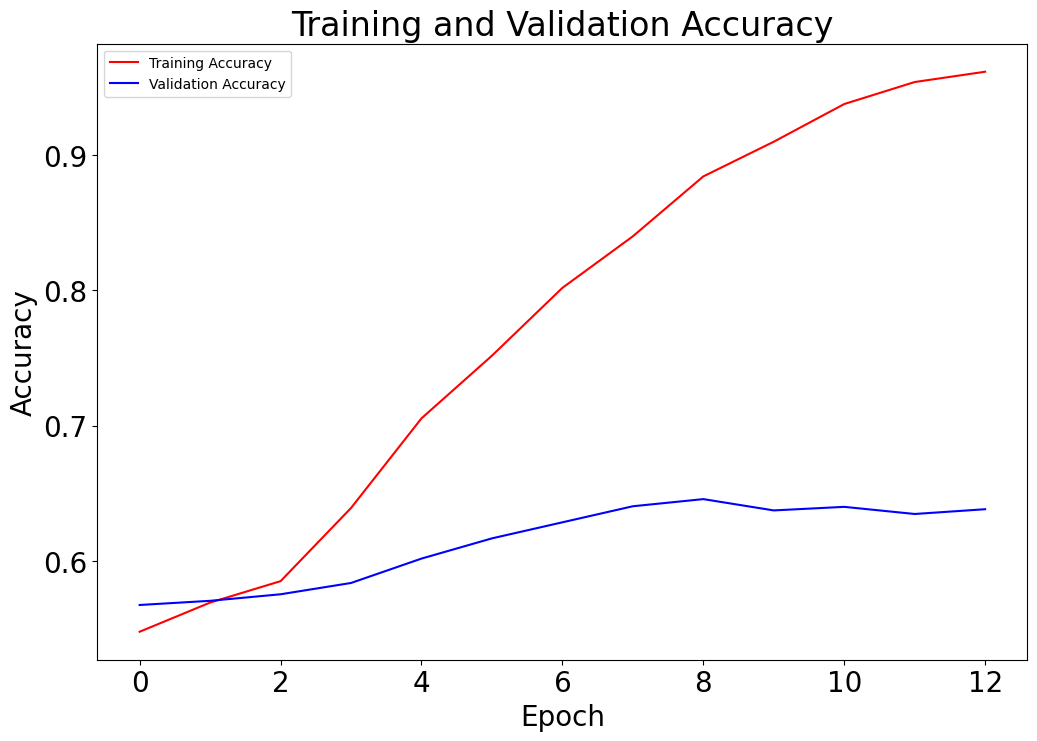

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax.plot(best_history.history['accuracy'], 'r', label='Training Accuracy')
ax.plot(best_history.history['val_accuracy'], 'b' ,label='Validation Accuracy')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.set_title('Training and Validation Accuracy', fontsize=24)
ax.legend()
ax.tick_params(labelsize=20)

fig.savefig('/Users/jackiecollopy/Downloads/project-reddit/notebooks/accuracy_plot.png') 

plt.show()

In [7]:
predictions = best_model_cnn.predict(X_val)
predictions = (predictions > 0.5).astype(int) 

f1 = f1_score(y_val, predictions)
print("F1 Score:", round(f1,3))
# Calculate Precision
precision = precision_score(y_val, predictions)
print("Precision:", round(precision, 3))
# Calculate recall
recall = recall_score(y_val, predictions)
print("Recall:", round(recall, 3))

72/72 [==============================] - 0s 2ms/step
F1 Score: 0.7
Precision: 0.641
Recall: 0.771


<Figure size 800x600 with 0 Axes>

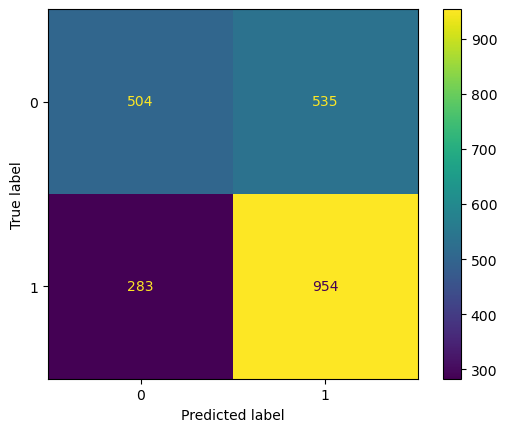

In [8]:
conf_matrix = confusion_matrix(y_val, predictions)

plt.figure(figsize=(8, 6))
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = [0,1])
cm_display.plot()

In [9]:
predictions = best_model_cnn.predict(X_test)
predictions = (predictions > 0.5).astype(int) 

f1 = f1_score(y_test, predictions)
print("F1 Score:", round(f1,3))
# Calculate Precision
precision = precision_score(y_test, predictions)
print("Precision:", round(precision, 3))
# Calculate recall
recall = recall_score(y_test, predictions)
print("Recall:", round(recall, 3))

NameError: name 'X_test' is not defined

<Figure size 800x600 with 0 Axes>

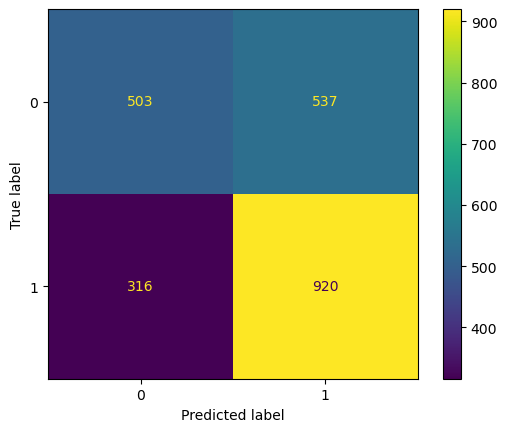

In [12]:
conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = [0,1])
cm_display.plot()